In [92]:
import torchdyn
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchdyn.numerics import AsynchronousLeapfrog
from torchdyn.numerics import odeint, odeint_symplectic

import torchdiffeq
import time 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [95]:
vf = nn.Sequential(nn.Linear(2, 32), nn.Tanh(), nn.Linear(32, 2))
class TestSystem(nn.Module):
    def __init__(self):
        super().__init__()
        self.nfe = 0

    def forward(self, t, x):
        self.nfe += 1
        return vf(x)

In [94]:
f = TestSystem()
x = torch.randn(1024, 2)
t_span = torch.linspace(0, 1, 500)

#### Fixed--step bench

In [88]:
t0 = time.time()
v = f(0., x)
#xv = torch.cat([x, v], -1)
solver = AsynchronousLeapfrog(-1, 'adaptive')
solver.x_shape = x.shape
t_eval, sol1 = odeint(f, x, t_span, solver=solver)
sol1 = torch.stack([x_[:4096//2].reshape(x.shape) for x_ in sol1])
t_end1 = time.time() - t0
print(t_end1)

t0 = time.time()
sol2 = torchdiffeq.odeint(f, x, t_span, method='rk4')
t_end2 = time.time() - t0
print(t_end2)

true_sol = torchdiffeq.odeint(f, x, t_span, method='dopri5', atol=1e-9, rtol=1e-9)

torch.Size([1024, 2]) torch.Size([1024, 2])
torch.Size([1024, 2]) torch.Size([1024, 2]) torch.Size([1024, 2])


RuntimeError: The size of tensor a (2) must match the size of tensor b (0) at non-singleton dimension 1

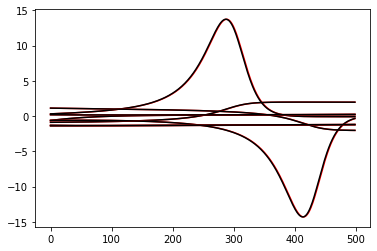

In [77]:
for i in range(4):
    plt.plot(sol1[:,i], c='r')
    plt.plot(sol2[:,i], c='black')

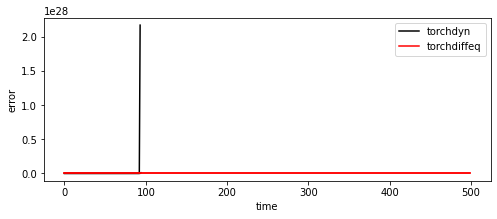

In [73]:
fig = plt.figure(figsize=(8,3))
ax = plt.subplot(111)
line, _ = ax.plot((sol1-true_sol).abs().mean(1), c='black')
line.set_label('torchdyn')
line, _ = ax.plot((sol2-true_sol).abs().mean(1), c='red')
line.set_label('torchdiffeq')
ax.set_ylabel('error')
ax.set_xlabel('time')
plt.legend()

#### Adaptive-step bench

In [347]:
t0 = time.time()
t_eval, sol1 = odeint(f, x, t_span, solver='dopri5', atol=1e-4, rtol=1e-4)
t_end1 = time.time() - t0
print(t_end1)

t0 = time.time()
sol2 = torchdiffeq.odeint(f, x, t_span, method='dopri5', atol=1e-4, rtol=1e-4)
t_end2 = time.time() - t0
print(t_end2)

true_sol = torchdiffeq.odeint(f, x, t_span, method='dopri5', atol=1e-9, rtol=1e-9)

0.18998932838439941
0.15713047981262207


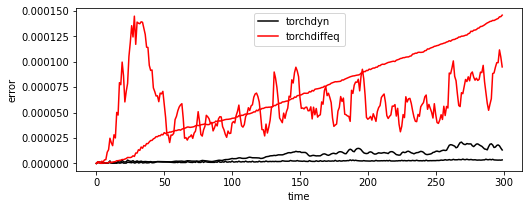

In [348]:
fig = plt.figure(figsize=(8,3))
ax = plt.subplot(111)
line, _ = ax.plot((sol1-true_sol).abs().mean(1), c='black')
line.set_label('torchdyn')
line, _ = ax.plot((sol2-true_sol).abs().mean(1), c='red')
line.set_label('torchdiffeq')
ax.set_ylabel('error')
ax.set_xlabel('time')
plt.legend()

### Using `ODEProblem`

In [349]:
from torchdyn.core import ODEProblem

f = VanDerPol(1)
t_span = torch.linspace(0, 1, 300)
x = torch.randn(1024, 2, requires_grad=True)

##### Backsolve Adjoint

* We are slower when the ODE is easy to solve due to the checkpointing strategy used that slows down `dt`

In [465]:
prob = ODEProblem(f, sensitivity='adjoint', solver='dopri5', atol=1e-3, rtol=1e-3, atol_adjoint=1e-3, rtol_adjoint=1e-3)
t0 = time.time()
t_eval, sol_torchdyn = prob.odeint(x, t_span)
t_end1 = time.time() - t0
print(t_end1)

t0 = time.time()
sol_torchdiffeq = torchdiffeq.odeint_adjoint(f, x, t_span, method='dopri5', atol=1e-3, rtol=1e-3)
t_end2 = time.time() - t0
print(t_end2)

true_sol = torchdiffeq.odeint_adjoint(f, x, t_span, method='dopri5', atol=1e-9, rtol=1e-9)

0.19397473335266113
0.02131962776184082


In [466]:
t0 = time.time()
grad1 = torch.autograd.grad(sol_torchdyn[-1].sum(), x)[0]
t_end1 = time.time() - t0
print(t_end1)

t0 = time.time()
grad2 = torch.autograd.grad(sol_torchdiffeq[-1].sum(), x)[0]
t_end2 = time.time() - t0
print(t_end2)

grad_true = torch.autograd.grad(true_sol[-1].sum(), x)[0]

0.7189087867736816
0.9237921237945557


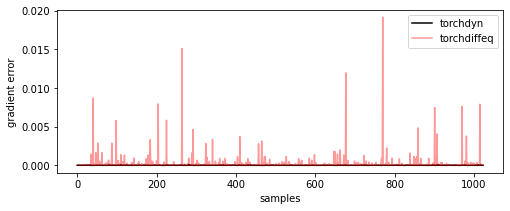

In [467]:
fig = plt.figure(figsize=(8,3))
ax = plt.subplot(111)
ax.plot((grad1-grad_true).abs().sum(1), c='black')
ax.plot((grad2-grad_true).abs().sum(1), c='red', alpha=0.4)
ax.set_ylabel('gradient error')
ax.set_xlabel('samples')
plt.legend(['torchdyn', 'torchdiffeq'])

##### Interpolated Adjoint

In [474]:
t0 = time.time()
prob = ODEProblem(f, sensitivity='interpolated_adjoint', solver='dopri5', atol=1e-4, rtol=1e-4)
t_eval, sol_torchdyn = prob.odeint(x, t_span)
t_end1 = time.time() - t0
print(t_end1)

t0 = time.time()
sol_torchdiffeq = torchdiffeq.odeint_adjoint(f, x, t_span, method='dopri5', atol=1e-4, rtol=1e-4)
t_end2 = time.time() - t0
print(t_end2)

true_sol = torchdiffeq.odeint_adjoint(f, x, t_span, method='dopri5', atol=1e-9, rtol=1e-9)

0.1861882209777832
0.02013564109802246


In [475]:
sol_torchdyn.shape

torch.Size([300, 1024, 2])

In [476]:
t0 = time.time()
grad1 = torch.autograd.grad(sol_torchdyn[-1].sum(), x)[0]
t_end1 = time.time() - t0
print(t_end1)

t0 = time.time()
grad2 = torch.autograd.grad(sol_torchdiffeq[-1].sum(), x)[0]
t_end2 = time.time() - t0
print(t_end2)

grad_true = torch.autograd.grad(true_sol[-1].sum(), x)[0]

1.061598777770996
0.9132266044616699


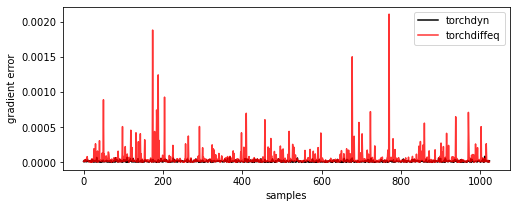

In [477]:
fig = plt.figure(figsize=(8,3))
ax = plt.subplot(111)
ax.plot((grad1-grad_true).abs().sum(1), c='black')
ax.plot((grad2-grad_true).abs().sum(1), c='red', alpha=0.8)
ax.set_ylabel('gradient error')
ax.set_xlabel('samples')
plt.legend(['torchdyn', 'torchdiffeq'])